In [1]:
import os
import sys
from chordUtils import json2lab
from subprocess import call
import json
import argparse
import chordUtils
import essentia.standard
import vamp
import numpy as np
import re
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


sns.set(style="white", context="talk")
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']

# Guitar "toy" dataset. Major triad.

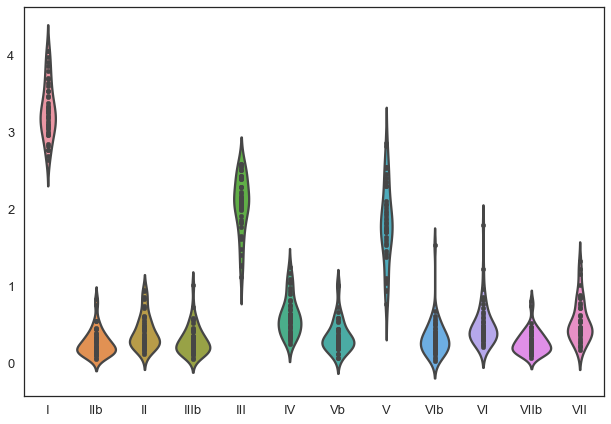

In [2]:
chromas, labels, kinds, mbids, start_times, durations = chordUtils.loadDatasetChroma('../guitar35.npz')
dMaj = pd.DataFrame(data=chromas[kinds == 'maj'], columns=degrees)
sns.violinplot(data=dMaj, inner="point")
plt.show()

# Guitar "toy" dataset. Major mixture (triad, maj7, maj6, maj69).

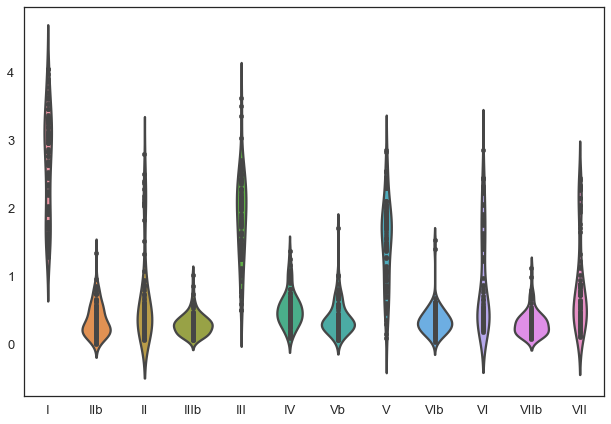

In [3]:
chromas, labels, kinds, mbids, start_times, durations = chordUtils.loadDatasetChroma('../guitar.npz')
dMaj = pd.DataFrame(data=chromas[kinds == 'maj'], columns=degrees)
sns.violinplot(data=dMaj, inner="point")
plt.show()

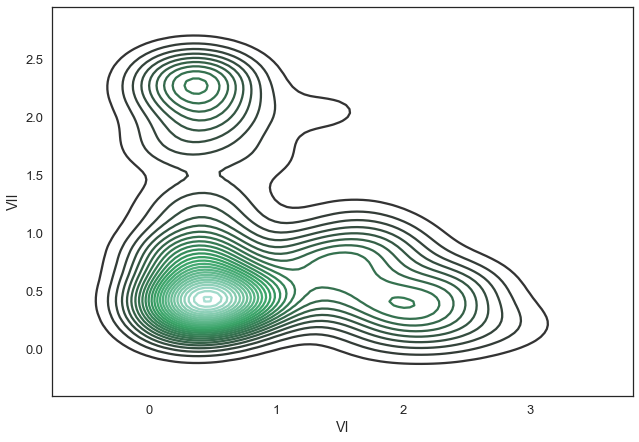

In [4]:
sns.kdeplot(dMaj['VI'], dMaj['VII'], n_levels=30)
plt.show()

In [12]:
chromas, labels, kinds, mbids, start_times, durations = chordUtils.loadDatasetChroma('../out.npz')
dMaj = pd.DataFrame(data=chromas[kinds == 'maj'], columns=degrees)
dMin = pd.DataFrame(data=chromas[kinds == 'min'], columns=degrees)
dDom = pd.DataFrame(data=chromas[kinds == 'dom'], columns=degrees)
dHdim = pd.DataFrame(data=chromas[kinds == 'hdim7'], columns=degrees)
dDim = pd.DataFrame(data=chromas[kinds == 'dim7'], columns=degrees)
totalDuration = np.sum(durations)
majDuration=sum(durations[kinds == 'maj'])
minDuration=sum(durations[kinds == 'min'])
domDuration=sum(durations[kinds == 'dom'])
hdimDuration=sum(durations[kinds == 'hdim7'])
dimDuration=sum(durations[kinds == 'dim7'])



# Jazz dataset. Tunes considered so far:

In [13]:
cat  ../ready.txt 

annotations/in_a_mellotone.json
annotations/swing_that_music.json
annotations/body_and_soul(hawkins).json
annotations/parkers_mood.json
annotations/west_end_blues.json
annotations/mean_to_me.json
annotations/minor_swing.json
annotations/st_thomas.json
annotations/dippermouth_blues.json
annotations/livery_stable_blues.json
annotations/i_found_a_new_baby.json
annotations/blue_horizon.json
annotations/tricotism.json
annotations/girl_from_ipanema.json
annotations/giant_steps.json
annotations/dinah.json
annotations/dinah_red_nichols.json
annotations/east_st_louis.json
annotations/cotton_tail.json


# Chord kind frequency. TODO: add more hdim7 (minor tunes)

In [14]:
print "Maj: ", len(dMaj), '(', len(dMaj) * 100 /len(chromas), '%) beats, ',majDuration,\
'(', majDuration*100/totalDuration, '%) sec'
print "Min: ", len(dMin), '(', len(dMin) * 100 /len(chromas), '%) beats, ',minDuration, 'sec',\
'(', minDuration*100/totalDuration, '%) sec'
print "Dom: ", len(dDom), '(', len(dDom) * 100 /len(chromas), '%) beats, ',domDuration, 'sec',\
'(', domDuration*100/totalDuration, '%) sec'
print "Hdim7: ", len(dHdim), '(', len(dHdim) * 100 /len(chromas), '%) beats, ',hdimDuration, 'sec',\
'(', hdimDuration*100/totalDuration, '%) sec'
print "Dim7: ", len(dDim), '(', len(dDim) * 100 /len(chromas), '%) beats, ',dimDuration, 'sec',\
'(', dimDuration*100/totalDuration, '%) sec'



Maj:  3943 ( 34 %) beats,  1433.61499999 ( 34.3598721961 %) sec
Min:  2209 ( 19 %) beats,  747.963999525 sec ( 17.9266730824 %) sec
Dom:  4143 ( 36 %) beats,  1549.90100081 sec ( 37.1469329665 %) sec
Hdim7:  87 ( 0 %) beats,  29.9799999297 sec ( 0.718539472611 %) sec
Dim7:  330 ( 2 %) beats,  124.469999656 sec ( 2.98320907667 %) sec


# Unclassified. TODO: dim->dim7, (3,6,9)/5 consider as major. Consider augmented.

In [15]:
unclassified = labels[kinds == 'unclassified']
Counter(unclassified).most_common(100)

[('N', 655), (u'D:aug', 12), (u'Bb:aug', 4), (u'Eb:(3,6,9)', 3)]

# Major

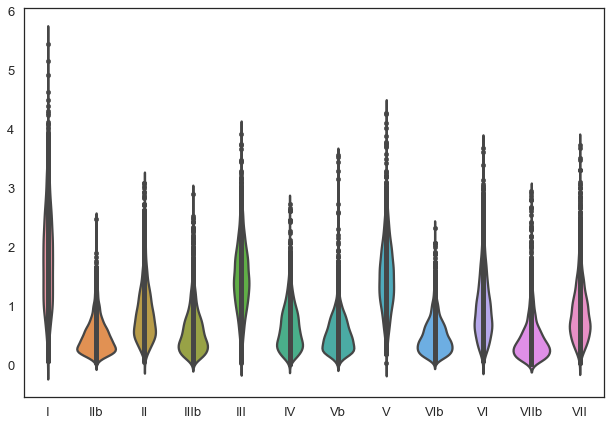

In [16]:


sns.violinplot(data=dMaj, inner="point")
plt.show()


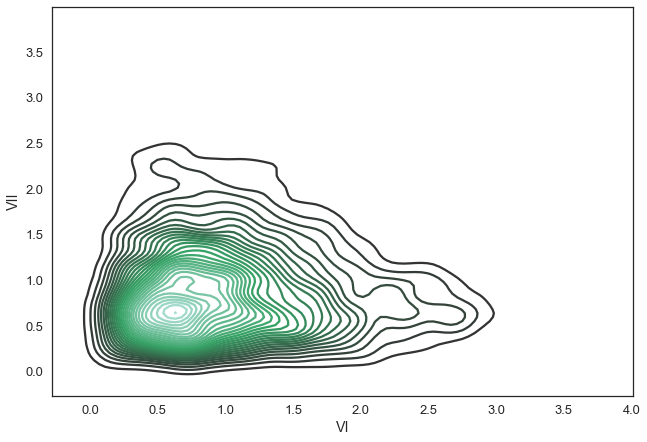

In [17]:
sns.kdeplot(dMaj['VI'], dMaj['VII'], n_levels=30)
plt.show()

# Minor

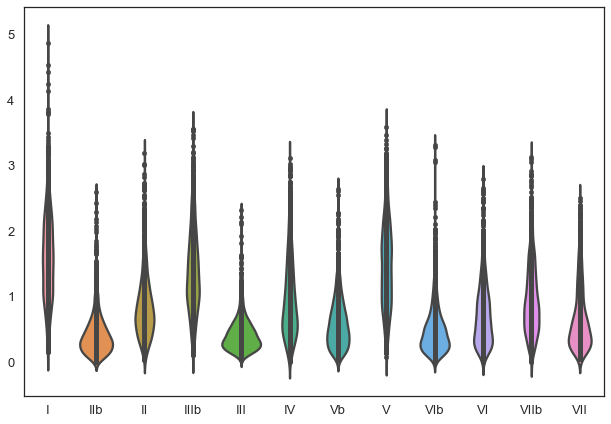

In [18]:
sns.violinplot(data=dMin, inner="point")
plt.show()



# Dominant

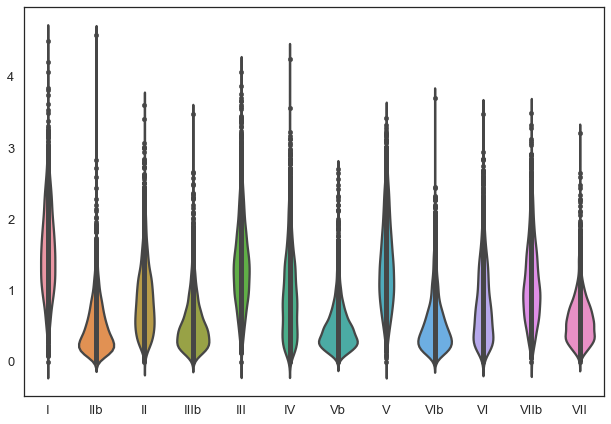

In [19]:
sns.violinplot(data=dDom, inner="point")
plt.show()


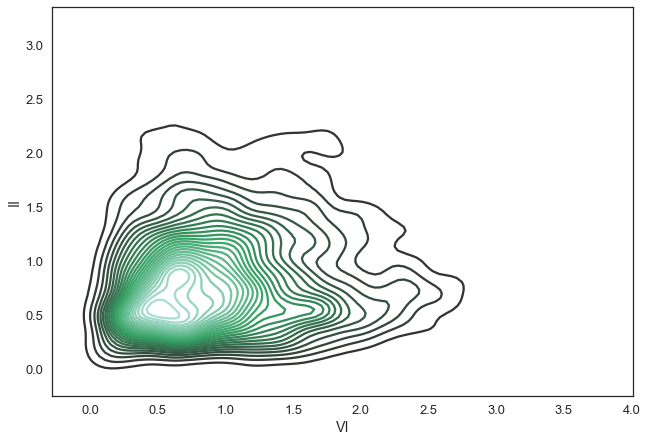

In [20]:
sns.kdeplot(dMaj['VI'], dMaj['II'], n_levels=30)
plt.show()

# Hdim7

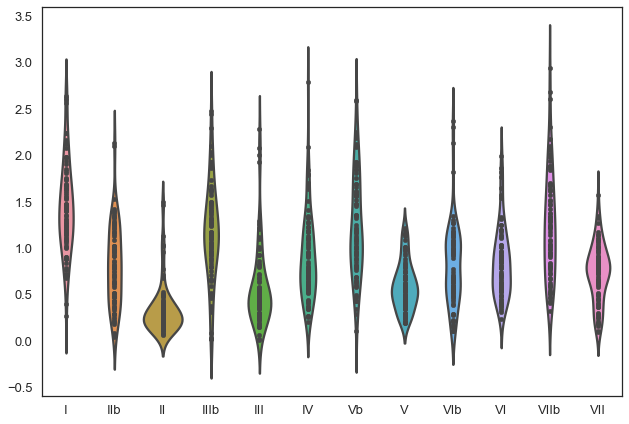

In [21]:
sns.violinplot(data=dHdim, inner="point")
plt.show()

# Dim7

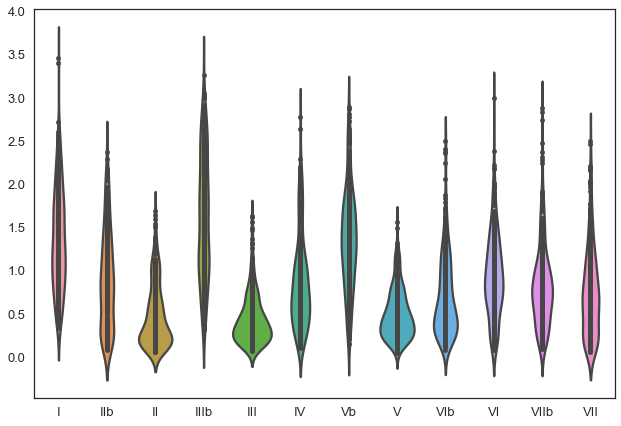

In [22]:
sns.violinplot(data=dDim, inner="point")
plt.show()